# Dynamics Vertical Triplet Energies Processor (DvTEProc)

## Import Depencies

In [17]:
from pathlib import Path
import csv, math
import pandas as pd
import re

import numpy as np
from numpy.random import seed
from numpy.random import randn

from scipy.stats import norm
from scipy.stats import t
from scipy.optimize import curve_fit
from scipy.ndimage.filters import gaussian_filter

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot

## Provide File Paths and Analysis details

List the paths where the raw Gaussian log files are located and molecule name as a list of lists: 
eg: [ ["Path1","Molecule_Name1"], ["Path2","Molecule_Name2"], etc]

Provide the the population cutoff for triplet energy prediction. This is an empirical value dependent on the level of they utilised in the QM calculations and MD simulations. 

Currently a value is only available for M06-2X/6-31G(d)//M06-2X/MIDI! and is set to 0.008

In [21]:
list_of_paths = [["/Ethene", "Ethene"],]

desired_population = 0.008

## Data Analysis

Using the paths and pecifications, this secotion of the code will perform the following operation:
1) Extract the Electronic energies from all files specified in the given path
2) Compile the data into a csv file named {MoleculeName}_output.csv
3) Construct a histogram a heatmap of relative energies on the S0 surface versus vertical triplet energies that is saved as {MoleculeName}_Vertical_Distribution.png
4) Construct a histogram of vertical triplet energies and fit a normal disitrbution to this data, which is then saved as {MoleculeName}_PDF.png
5) Using the fitted normal distribution, a cumulative distribution function (CDF) is constructed and is saved as
{MoleculeName}_CDF.png
6) A quartile-quartile plot is constructed to confirm the narmality of the collected data and saved as {name}_QQ_Plot.png
7) A prediction of triplet energy is made usign the CDF at the chosen population 

CSV file for Ethene created: Ethene_output.csv


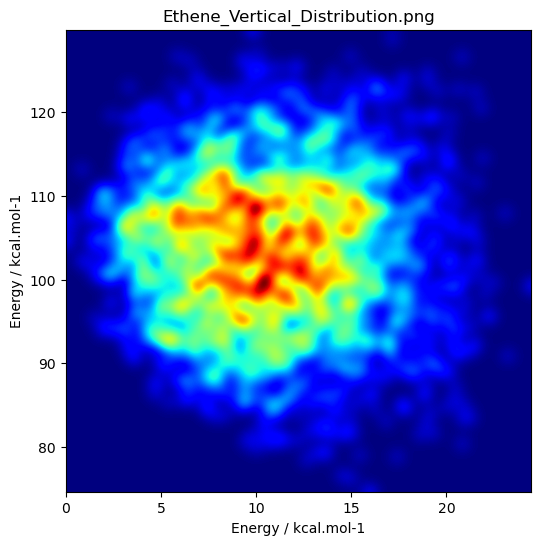

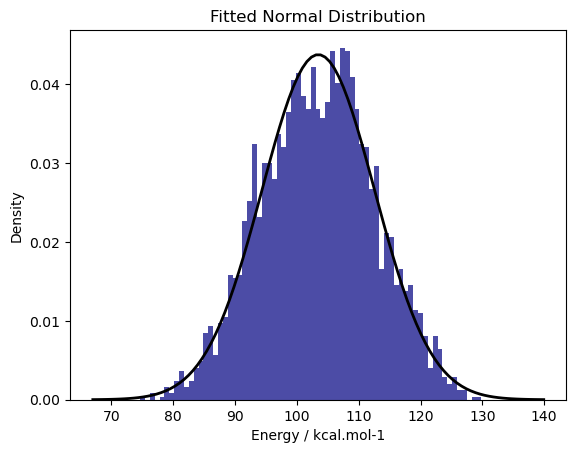

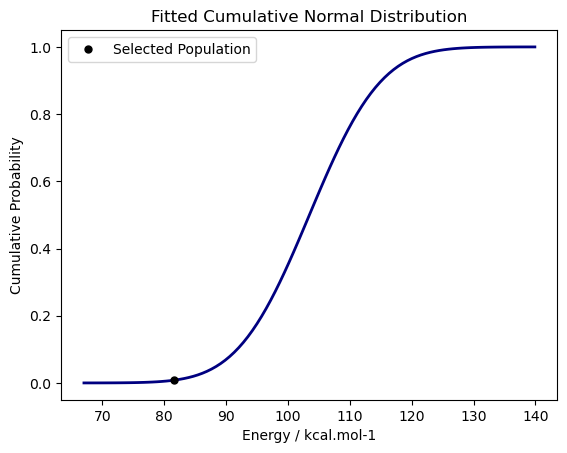

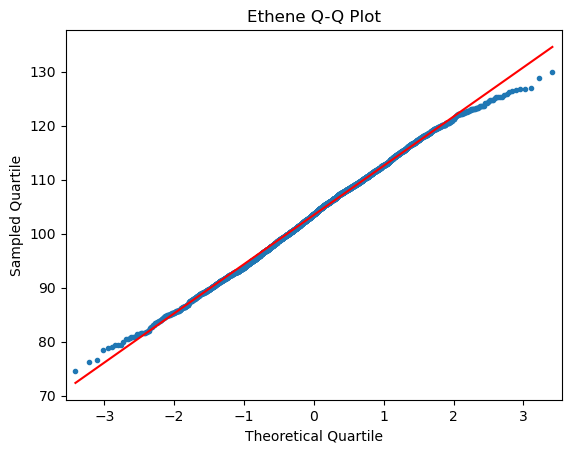

μ = 103.46401912968862 σ = 9.113584240127684

Triplet Energy for desired population of 0.008 is 81.51016437554625


In [25]:
# Create a new list with the desired strings
output_list = [f"{entry[1]}_output.csv" for entry in list_of_paths]

def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

for path_info in list_of_paths:
    path, name = path_info
    
    # Load .log Files
    log_files = [str(filepath) for filepath in Path(path).glob('*.log')]

    # Specify the name of the output CSV file based on the desired name
    output_file = f'{name}_output.csv'

    # Extract Energies and Save as a .csv file
    with open(output_file, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['File_name', 'Energy'])  # Write the header row

        for file in log_files:
            file_name = str(file)
            search_string = 'SCF Done:'
            with open(file, 'r') as file:
                found = False
                for line in file:
                    if search_string in line:
                        found = True
                        words = line.split()
                        if len(words) >= 5:
                            csv_writer.writerow([file_name, words[4]])  # Write the data row
                        break

    # Open the CSV file using pandas
    df = pd.read_csv(output_file)

    # Create a new column to store energy difference to store the updated values
    df['dE'] = df['Energy']

    # Find matching entries and subtract Singlets and Triplets and append to dE
    for idx, row in df.iterrows():
        file_name = row['File_name']
        pattern = r'(.*)_T1\.log'
        match = re.match(pattern, file_name)
        if match:
            corresponding_file = match.group(1) + '_S0.log'
            corresponding_value = df.loc[df['File_name'] == corresponding_file, 'Energy'].values
            if len(corresponding_value) > 0:
                df.at[idx, 'dE'] -= corresponding_value[0]

    # Drop S0 entries
    df = df[~df['File_name'].str.endswith('_S0.log')]

    # Convert from Hartree to kcal/mol
    df['dE'] = df['dE'] * 627.5
    df['Energy'] = df['Energy'] * 627.5
    df['dS0'] = df['Energy'] - df['dE'] - (df['Energy'] - df['dE']).min()
    df['dT1'] = df['Energy'] - (df['Energy'] - df['dE']).min()

    # Print and save the DataFrame to a new CSV file
    df.to_csv(output_file, index=False)
    print(f'CSV file for {name} created: {output_file}')

    
    # Plot the figure using the generated data
    x = df['dS0']
    y = df['dE']

    # Create a figure with a specified size (adjust the numbers as needed)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(np.random.random((100, 150)), extent=[0, 100, 60, 120], origin='lower', cmap='gray')

    # Plot the heatmap with equal aspect ratio
    img, extent = myplot(x, y, 16)
    ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet, aspect='auto')
    
    # Show the plot
    plt.title(f'{name}_Vertical_Distribution.png')
    plt.xlabel('Energy / kcal.mol-1')
    plt.ylabel('Energy / kcal.mol-1')
    plt.show()
    
    # Save the figure if needed
    fig.savefig(f'{name}_Vertical_Distribution.png')
    
    # Calculate mean and standard deviation
    mu = df['dE'].mean()
    sigma = df['dE'].std()

    # Generate range of values
    x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 100)

    # Generate Gaussian distribution
    gaussian = norm(mu, sigma)

    # Calculate PDF for Gaussian distribution
    pdf = gaussian.pdf(x)

    #Plot histogram
    plt.hist(df['dE'], bins=70, density=True, alpha=0.7, color='navy', label='Vertical TE')

    # Plot fitted Gaussian distribution curve
    plt.plot(x, pdf, color='black', linewidth=2)

    # Display plot
    plt.title('Fitted Normal Distribution')
    plt.xlabel('Energy / kcal.mol-1')
    plt.ylabel('Density')
    #plt.legend()
    plt.savefig(f"{name}_PDF.png", dpi=200)
    plt.show()
       
    # Calculate CDF for Gaussian distribution
    cdf = norm.cdf(x, loc=mu, scale=sigma)

    # Find corresponding x value for desired y value
    x_value = norm.ppf(desired_population, loc=mu, scale=sigma)

    # Plot CDF
    plt.plot(x, cdf, color='navy', linewidth=2)

    # Add a marker for the desired y value
    plt.plot(x_value, desired_population, 'o', markersize=5, label='Selected Population', color='black')

    # Add legend
    plt.legend()

    # Display plot
    plt.title('Fitted Cumulative Normal Distribution')
    plt.xlabel('Energy / kcal.mol-1')
    plt.ylabel('Cumulative Probability')
    plt.savefig(f"{name}_CDF.jpg", dpi=200)
    plt.show()
    
    
    # q-q plot
    qqplot(df['dE'], line='s', markersize=3)
    plt.title(f'{name} Q-Q Plot')
    plt.xlabel('Theoretical Quartile')
    plt.ylabel('Sampled Quartile')
    plt.savefig(f"{name}_QQ_Plot.png", dpi=200)
    pyplot.show()
    
    # Print Fitted Normal Distribution Paramenters and Predicted Triplet Energy at Given Population

    print('\u03BC =', mu, '\u03C3 =', sigma)
    print()

    # Print the x value
    print("Triplet Energy for desired population of", desired_population, "is", x_value)

    
    